In [1]:
import json
import pandas as pd
#import reddit api query script
from RedditAnalyzer.get_data import RedditScraper
from RedditAnalyzer.analyze_text import CreateTopicModel

#read app info
with open('reddit_app.json') as rd_f:
    data = json.load(rd_f)

Extract Data from Reddit

In [2]:
#log into to reddit api and custom scraper using app credentials
reddit = RedditScraper(client_id=data['client'], client_secret=data['secret'], user_agent=data['user'])

In [3]:
#subreddit to create topic model for
subreddit = 'ask'

In [4]:
#use custom scraper and subreddit posts function to query from channel
top_week = reddit.subreddit_posts(subreddit, time_filt='week', with_comments=False)
top_week[:2]

Display Name: ask
Title: /r/Ask
Posts: 1,000 | Comments: 0


,text,uid,score,pid,created,parent
0,Is it common to urinate while taking a shower?...,18sqdz8,7507,18sqdz8,1.703757e+09,1
1,What did teenagers in the 90s do on their free...,18wbrk1,4131,18wbrk1,1.704156e+09,1


In [5]:
#use custom scraper and subreddit posts function to query from channel
top_month = reddit.subreddit_posts(subreddit, time_filt='month', with_comments=False)

#remove posts that are also in top_week
top_month = top_month.loc[~top_month['pid'].isin(top_week['pid'].tolist())].reset_index(drop=True)
top_month[:2]

Display Name: ask
Title: /r/Ask
Posts: 991 | Comments: 0


,text,uid,score,pid,created,parent
0,Why are 18 year olds old enough to die in war ...,18egble,7356,18egble,1.702137e+09,1
1,"What is a true fact so baffling, it should be ...",18q79h2,6126,18q79h2,1.703463e+09,1


In [7]:
save_data = False

if save_data:
    top_week.to_pickle('./week.pkl')
    top_month.to_pickle('./month.pkl')

Explore Data

In [8]:
read_files = False

if read_files:
    top_week = pd.read_pickle('./week.pkl')
    top_month = pd.read_pickle('./month.pkl')

In [9]:
import string, re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from PIL import Image

#set matplotlib style
plt.style.use("dark_background")

stop_words = stopwords.words('english') + ['like']

In [10]:
def clean_text(sentence):
    #replace multiple spaces, tabs, new lines, etc
    sentence = re.sub('\s{2,}', ' ', sentence)
    #remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    #split tokens
    sentence = sentence.lower().split()
    #remove stop words
    sentence = [word for word in sentence if word not in stop_words]
    return sentence

def bar_chart(ax, data, title, n_words=10):
    #explode series of tokens and get value count of words
    word_counts = data['text_tokens'].explode().value_counts()[:n_words]
    #plot bar graph
    word_counts.plot(kind='bar', color='#1a3258', edgecolor='black', ax=ax)
    ax.set_xticklabels(word_counts.index, rotation=45)
    ax.set_title(title)

    for idx, val in enumerate(word_counts):
        ax.text(idx, val, f"{val:,}", ha='center')

def generate_wordcloud(ax, data, title, mask=None):
    #create one corpus of all text
    data_corpus = ' '.join(data['text_tokens'].explode())
    #create wordcloud
    cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='RdYlGn',
                      mask=255 - mask,
                      background_color='black',
                      stopwords=stop_words,
                      collocations=True,
                      contour_color='#5d0f24',
                      contour_width=3).generate_from_text(data_corpus)
    ax.imshow(cloud)
    ax.axis('off')
    ax.set_title(title)

In [11]:
#clean text variable
top_week['text_tokens'] = top_week['text'].apply(lambda sent: clean_text(sent))
top_month['text_tokens'] = top_month['text'].apply(lambda sent: clean_text(sent))


#remove rows with no tokens after stopword removal
top_week = top_week.loc[top_week['text_tokens'].apply(lambda lst: lst != [])].reset_index(drop=True)
top_month = top_month.loc[top_month['text_tokens'].apply(lambda lst: lst != [])].reset_index(drop=True)

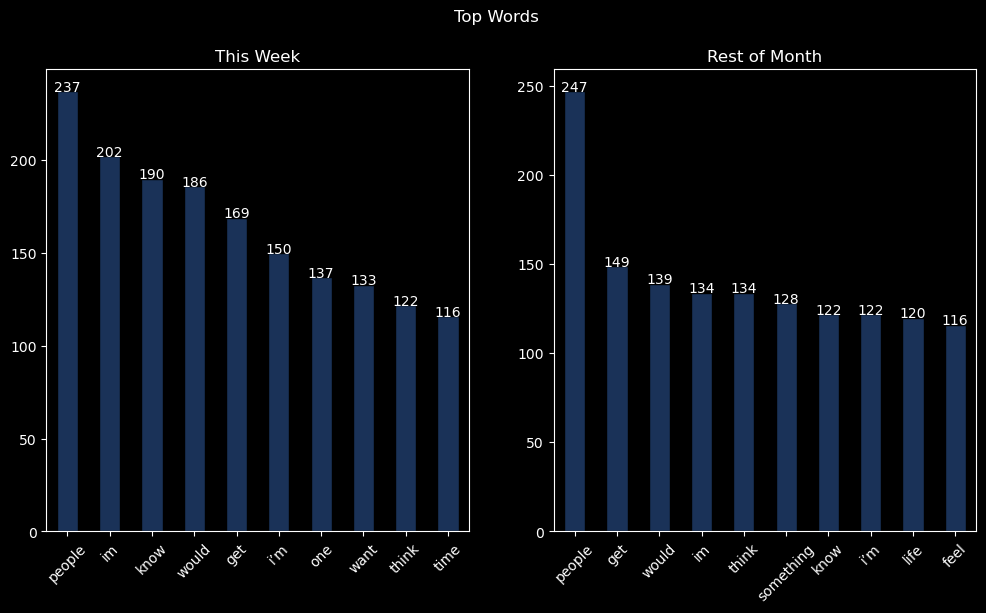

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#bra graphs to compare posts and comments
bar_chart(ax1, top_week, 'This Week', 10)
bar_chart(ax2, top_month, 'Rest of Month', 10)
fig.suptitle('Top Words')
plt.show()

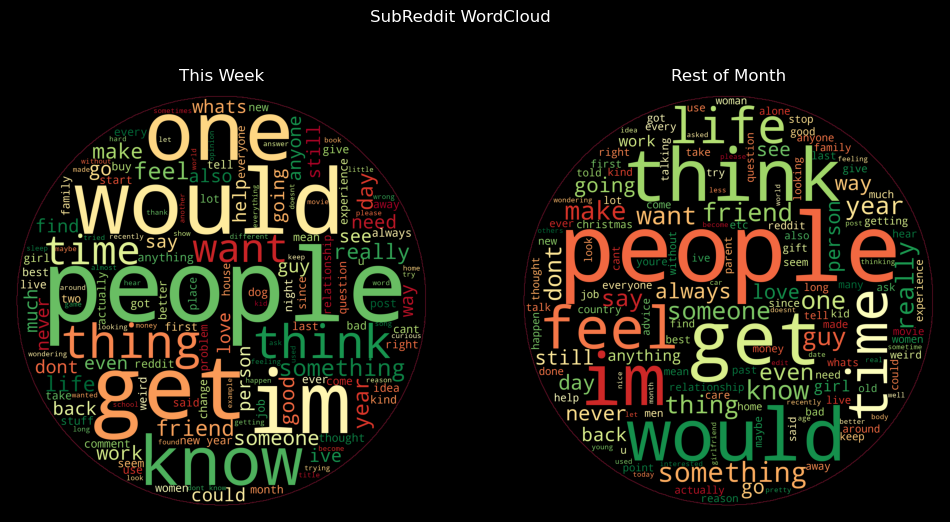

In [13]:
#import pokemon logo as mask
mask = Image.open('./RedditAnalyzer/RedditLogo.png')
mask = np.array(mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#use function to generate wordcloud
generate_wordcloud(ax1, top_week, 'This Week', mask=mask)
generate_wordcloud(ax2, top_month, 'Rest of Month', mask=mask)
fig.suptitle('SubReddit WordCloud')
plt.show()

Topic Modeling

In [14]:
#total trials for optuna to iterate through
num_trials = 60

#instantiate topic modeling class for weekly data
topic_modeler = CreateTopicModel(df=top_week, column_name='text', use_hdbscan=False)

#create topic model for dataset and tune hyperparameters of model
topics, topic_model = topic_modeler.find_hyperparams(num_trials=num_trials)
#show topic labels
print(topic_model.generate_topic_labels())
topics.groupby('topic').agg({'text': len}).T

['0_just_girl_like', '1_smell_help_bad', '2_amazon_card_sell', '3_like_dream_sleep', '4_people_like_ve', '5_mining_country_stocks', '6_watch_movies_game', '7_people_reddit_know', '8_relationship_love_just', '9_job_did_time', '10_life_think_person', '11_thing_think_witnessed', '12_2024_resolution_year', '13_dogs_body_common', '14_feel_life_just', '15_food_scratch_pregnancy', '16_song_songs_gypsy', '17_karma_reddit_comment', '18_new_year_new years']


topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
text,82,77,70,70,64,62,59,59,57,56,53,51,45,42,40,40,31,22,20


In [15]:
#instantiate topic modeling class for monthly data
topic_modeler = CreateTopicModel(df=top_month, column_name='text', use_hdbscan=False)

#create topic model for dataset and tune hyperparameters of model
topics_m, topic_model_m = topic_modeler.find_hyperparams(num_trials=num_trials)
#show topic labels
print(topic_model_m.generate_topic_labels())
topics_m.groupby('topic').agg({'text': len}).T

['0_people_like_bad', '1_christmas_alcohol_just', '2_like_know_just', '3_relationship_love_just', '4_life_new_love', '5_people_death_like', '6_time_feel_life', '7_guy_guys_know', '8_say_language_weird', '9_gift_socks_christmas', '10_real_dream_public', '11_life_thing_did', '12_men_women_attractive', '13_rich_people_wage', '14_reddit_social media_media', '15_friends_women_people', '16_food_eat_actually', '17_2024_happen_think happen', '18_country_live_countries', '19_song_makes_song makes']


topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
text,73,53,52,47,47,45,45,43,41,40,39,38,37,36,31,30,28,22,11,9


Compare Topics

In [16]:
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

#cosine similarity function
def cosine_sim(x, y):
    return 1 - cosine(x, y)

In [21]:
#get keywords for each topic
week_topics = [[word[0] for word in topic_model.get_topic(i)][:6] for i in range(len(topic_model.generate_topic_labels()))]
month_topics = [[word[0] for word in topic_model_m.get_topic(i)][:6] for i in range(len(topic_model_m.generate_topic_labels()))]

#encode keywords for each topic and then take the average
week_encodings = [model.encode(top).mean(axis=0) for top in week_topics]
month_encodings = [model.encode(top).mean(axis=0) for top in month_topics]

#compare week topics to month topics
high_sim = []
for x in range(len(week_encodings)):
    for y in range(len(month_encodings)):
        sim = cosine_sim(week_encodings[x], month_encodings[y])
        if sim > 0.80:
            high_sim.append((x, y, sim))

Repeat Topics This Week

In [22]:
#save high similarity topics into dataframe
sim_df = pd.DataFrame([('_'.join([word[0] for word in topic_model.get_topic(sim[0])[:4]]),
                        '_'.join([word[0] for word in topic_model_m.get_topic(sim[1])[:4]]),
                        sim[2]) for sim in high_sim], columns=['topic_week', 'topic_month', 'sim'])
sim_df

,topic_week,topic_month,sim
0,just_girl_like_women,friends_women_people_don,0.853866
1,people_like_ve_don,people_like_bad_don,0.885658
2,people_like_ve_don,like_know_just_flowers,0.812882
3,relationship_love_just_people,people_like_bad_don,0.801984
4,relationship_love_just_people,like_know_just_flowers,0.803479
5,life_think_person_moment,rich_people_wage_think,0.851270
6,feel_life_just_2000,time_feel_life_sleep,0.839399


In [27]:
print(set(sim_df['topic_week']))

{'just_girl_like_women', 'people_like_ve_don', 'feel_life_just_2000', 'life_think_person_moment', 'relationship_love_just_people'}


New Topics This Week

In [41]:
#topics that were represented in the month and week dataset
repeat_topics = set([tup[0] for tup in high_sim])

#topics that are new in the most recent dataset
new_topics = set([top for top in topics['topic'].unique() if top not in repeat_topics])
new_topic_labels = ['_'.join([word[0] for word in topic_model.get_topic(top)[:4]]) for top in new_topics]
print(new_topic_labels)

['smell_help_bad_cold', 'amazon_card_sell_use', 'like_dream_sleep_weight', 'mining_country_stocks_money', 'watch_movies_game_movie', 'people_reddit_know_message', 'job_did_time_school', 'thing_think_witnessed_night', '2024_resolution_year_2023', 'dogs_body_common_dog', 'food_scratch_pregnancy_pregnancy test', 'song_songs_gypsy_celebrity', 'karma_reddit_comment_post', 'new_year_new years_years']


Cluster Hierarchies

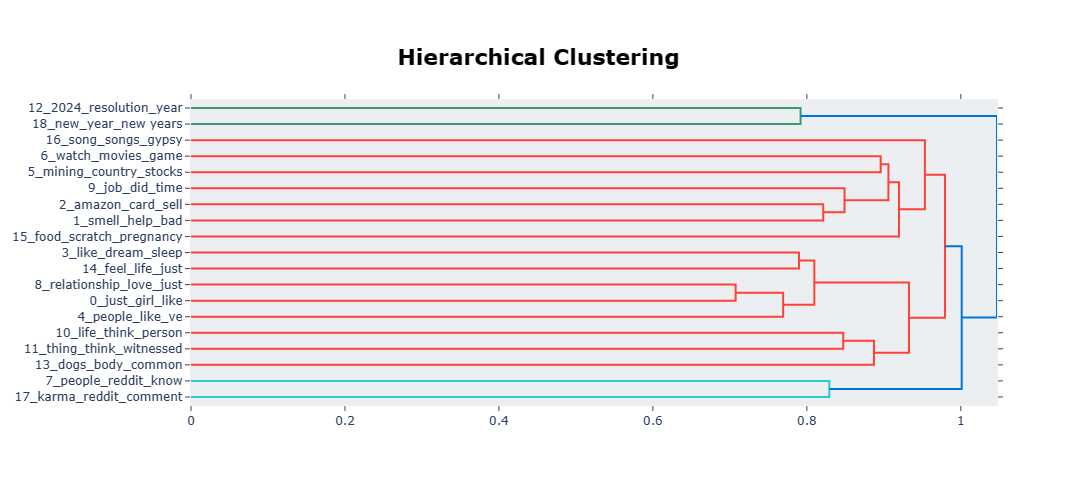

In [42]:
topic_model.visualize_hierarchy()

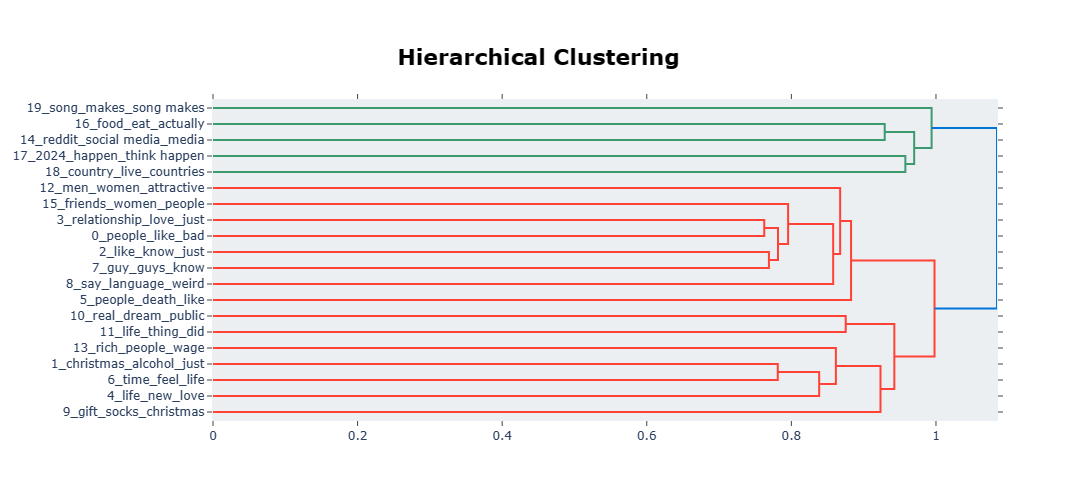

In [43]:
topic_model_m.visualize_hierarchy()